In [1]:
from transformers import pipeline

pipe = pipeline(task="automatic-speech-recognition",
                model="openai/whisper-base",
                device="cuda")

2023-07-21 11:43:31.645369: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-21 11:43:31.645465: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-07-21 11:43:31.645473: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [39]:
from datasets import load_dataset

dataset = load_dataset("facebook/voxpopuli", "it", split="validation", streaming=True)
sample = next(iter(dataset))

In [3]:
from IPython.display import Audio

Audio(sample["audio"]["array"], rate=sample["audio"]["sampling_rate"])

In [4]:
def translate_audio(audio):
    return pipe(audio, generate_kwargs={"task":"translate"})["text"]

In [6]:
translate_audio(sample["audio"].copy())

/home/susnato/temp_files/transformers/src/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (448) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


' psychological and social. I think that it is a very important step in the construction of a juridical space of freedom, circulation and protection of rights.'

In [7]:
sample["raw_text"]

'Penso che questo sia un passo in avanti importante nella costruzione di uno spazio giuridico di libertà di circolazione e di protezione dei diritti per le persone in Europa.'

In [9]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")

model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts").to("cuda")
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan").to("cuda")

In [10]:
import torch

embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

Found cached dataset cmu-arctic-xvectors (/home/susnato/.cache/huggingface/datasets/Matthijs___cmu-arctic-xvectors/default/0.0.1/a62fea1f9415e240301ea0042ffad2a3aadf4d1caa7f9a8d9512d631723e781f)


In [68]:
def tts(text):
    processed = processor(text=text, truncation=True, return_tensors="pt")
    waveform = model.generate_speech(processed["input_ids"].to("cuda"),
                                        speaker_embeddings.to("cuda"),
                                        vocoder=vocoder)
    return waveform.cpu()


In [14]:
speech = tts("Hey there! This is a test!")

Audio(speech, rate=16000)

In [62]:
import numpy as np

MAX_INT16_VALUE = np.iinfo(np.int16).max

def STST(speech): # speech to speech translation
    translated_text = translate_audio(speech)
    translated_speech = tts(translated_text).numpy()
    translated_speech = (translated_speech * MAX_INT16_VALUE).astype(np.int16)

    return 16_000, translated_speech

In [46]:
Audio(sample["audio"]["array"], rate=16_000)

In [47]:
sampling_rate, synthesised_speech = STST(sample["audio"].copy())

Audio(synthesised_speech, rate=sampling_rate)

In [69]:
import gradio as gr

demo = gr.Blocks()

mic_translate = gr.Interface(
    fn=STST,
    inputs=gr.Audio(source="microphone", type="filepath"),
    outputs=gr.Audio(label="Generated Speech", type="numpy"),
)

file_translate = gr.Interface(
    fn=STST,
    inputs=gr.Audio(source="upload", type="filepath"),
    outputs=gr.Audio(label="Generated Speech", type="numpy"),
)

with demo:
    gr.TabbedInterface([mic_translate, file_translate], ["Microphone", "Audio File"])

demo.launch(debug=True)

/home/susnato/anaconda3/envs/transformers/lib/python3.9/site-packages/gradio/blocks.py:922: UserWarning: api_name predict already exists, using predict_1
  warnings.warn(


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


/home/susnato/temp_files/transformers/src/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/home/susnato/temp_files/transformers/src/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (448) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/susnato/temp_files/transformers/src/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/home/susnato/temp_files/transformers/src/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (448) to control the generation length. This behaviour is deprecated and will be remov

Keyboard interruption in main thread... closing server.


In [70]:
from transformers import pipeline
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"

classifier = pipeline(
    "audio-classification", model="MIT/ast-finetuned-speech-commands-v2", device=device
)

In [71]:
classifier.model.config.id2label

{0: 'backward',
 1: 'follow',
 2: 'five',
 3: 'bed',
 4: 'zero',
 5: 'on',
 6: 'learn',
 7: 'two',
 8: 'house',
 9: 'tree',
 10: 'dog',
 11: 'stop',
 12: 'seven',
 13: 'eight',
 14: 'down',
 15: 'six',
 16: 'forward',
 17: 'cat',
 18: 'right',
 19: 'visual',
 20: 'four',
 21: 'wow',
 22: 'no',
 23: 'nine',
 24: 'off',
 25: 'three',
 26: 'left',
 27: 'marvin',
 28: 'yes',
 29: 'up',
 30: 'sheila',
 31: 'happy',
 32: 'bird',
 33: 'go',
 34: 'one'}

In [72]:
classifier.model.config.id2label[27]

'marvin'

In [80]:
from transformers.pipelines.audio_utils import ffmpeg_microphone_live


def launch_fn(
    wake_word="marvin",
    prob_threshold=0.5,
    chunk_length_s=10.0, # 2.0
    stream_chunk_s=0.5, # 0.25
    debug=False,
):
    if wake_word not in classifier.model.config.label2id.keys():
        raise ValueError(
            f"Wake word {wake_word} not in set of valid class labels, pick a wake word in the set {classifier.model.config.label2id.keys()}."
        )

    sampling_rate = classifier.feature_extractor.sampling_rate

    mic = ffmpeg_microphone_live(
        sampling_rate=sampling_rate,
        chunk_length_s=chunk_length_s,
        stream_chunk_s=stream_chunk_s,
    )

    print("Listening for wake word...")
    for prediction in classifier(mic):
        prediction = prediction[0]
        if debug:
            print(prediction)
        if prediction["label"] == wake_word:
            if prediction["score"] > prob_threshold:
                return True

In [82]:
launch_fn(debug=True)

Listening for wake word...


In [83]:
transcriber = pipeline(
    "automatic-speech-recognition", model="openai/whisper-small.en", device=device
)

In [95]:
import sys


def transcribe(chunk_length_s=10.0, stream_chunk_s=2.0):
    sampling_rate = transcriber.feature_extractor.sampling_rate

    mic = ffmpeg_microphone_live(
        sampling_rate=sampling_rate,
        chunk_length_s=chunk_length_s,
        stream_chunk_s=stream_chunk_s,
    )

    print("Start speaking...")
    for item in transcriber(mic, generate_kwargs={"max_new_tokens": 128}):
        sys.stdout.write("\033[K")
        print(item["text"], end="\r")
        if not item["partial"][0]:
            break

        return item["text"]

In [96]:
transcribe()

Start speaking...


In [97]:
from huggingface_hub import HfFolder
import requests


def query(text, model_id="tiiuae/falcon-7b-instruct"):
    api_url = f"https://api-inference.huggingface.co/models/{model_id}"
    headers = {"Authorization": f"Bearer {HfFolder().get_token()}"}
    payload = {"inputs": text}

    print(f"Querying...: {text}")
    response = requests.post(api_url, headers=headers, json=payload)
    return response.json()[0]["generated_text"][len(text) + 1 :]

In [98]:
query("What does Hugging Face do?")

Querying...: What does Hugging Face do?


'Hugging Face is a company that provides natural language processing and machine learning tools for developers. They'

In [99]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")

model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts").to(device)
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan").to(device)

In [100]:
from datasets import load_dataset

embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

Found cached dataset cmu-arctic-xvectors (/home/susnato/.cache/huggingface/datasets/Matthijs___cmu-arctic-xvectors/default/0.0.1/a62fea1f9415e240301ea0042ffad2a3aadf4d1caa7f9a8d9512d631723e781f)


In [101]:
def synthesise(text):
    inputs = processor(text=text, return_tensors="pt")
    speech = model.generate_speech(
        inputs["input_ids"].to(device), speaker_embeddings.to(device), vocoder=vocoder
    )
    return speech.cpu()

In [102]:
from IPython.display import Audio

audio = synthesise(
    "Hugging Face is a company that provides natural language processing and machine learning tools for developers."
)

Audio(audio, rate=16000)

In [106]:
launch_fn()
transcription = transcribe()
response = query(transcription)
audio = synthesise(response)

Audio(audio, rate=16000, autoplay=True)

Listening for wake word...
Start speaking...
Querying...: None


/home/susnato/temp_files/transformers/src/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /home/susnato/anaconda3/envs/transformers/lib/python3.9/site-packages/requests/models.py: │
│ 971 in json                                                                               │
│                                                                                           │
│    968 │   │   │   │   │   raise RequestsJSONDecodeError(e.msg, e.doc, e.pos)             │
│    969 │   │                                                                              │
│    970 │   │   try:                                                                       │
│ ❱  971 │   │   │   return complexjson.loads(self.text, **kwargs)                          │
│    972 │   │   except JSONDecodeError as e:                                               │
│    973 │   │   │   # Catch JSON-related errors and raise as requests.JSONDecodeError      │
│    974 │   │   │   # This aliases json.JSONDecodeError and simplejson.JSONDecodeError     │
│ /home/susnato/anaconda3/envs/transformers/lib/python3.9/json/__init__.py:346 in loads     │
│                                                                                           │
│   343 │   if (cls is None and object_hook is None and                                     │
│   344 │   │   │   parse_int is None and parse_float is None and                           │
│   345 │   │   │   parse_constant is None and object_pairs_hook is None and not kw):       │
│ ❱ 346 │   │   return _default_decoder.decode(s)                                           │
│   347 │   if cls is None:                                                                 │
│   348 │   │   cls = JSONDecoder                                                           │
│   349 │   if object_hook is not None:                                                     │
│                                                                                           │
│ /home/susnato/anaconda3/envs/transformers/lib/python3.9/json/decoder.py:337 in decode     │
│                                                                                           │
│   334 │   │   containing a JSON document).                                                │
│   335 │   │                                                                               │
│   336 │   │   """                                                                         │
│ ❱ 337 │   │   obj, end = self.raw_decode(s, idx=_w(s, 0).end())                           │
│   338 │   │   end = _w(s, end).end()                                                      │
│   339 │   │   if end != len(s):                                                           │
│   340 │   │   │   raise JSONDecodeError("Extra data", s, end)                             │
│                                                                                           │
│ /home/susnato/anaconda3/envs/transformers/lib/python3.9/json/decoder.py:355 in raw_decode │
│                                                                                           │
│   352 │   │   try:                                                                        │
│   353 │   │   │   obj, end = self.scan_once(s, idx)                                       │
│   354 │   │   except StopIteration as err:                                                │
│ ❱ 355 │   │   │   raise JSONDecodeError("Expecting value", s, err.value) from None        │
│   356 │   │   return obj, end                                                             │
│   357                                                                                     │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
JSONDecodeError: Expecting value: line 1 column 1 (char 0)

During handling of the above exception, another exception occurred:

╭────────────────

In [107]:
from transformers import HfAgent

agent = HfAgent(
    url_endpoint="https://api-inference.huggingface.co/models/bigcode/starcoder"
)

==Explanation from the agent==
I will use the following  tool: `image_generator` to generate an image of a cat.


==Code generated by the agent==
image = image_generator(prompt="cat")


==Result==


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/25 [00:00<?, ?it/s]

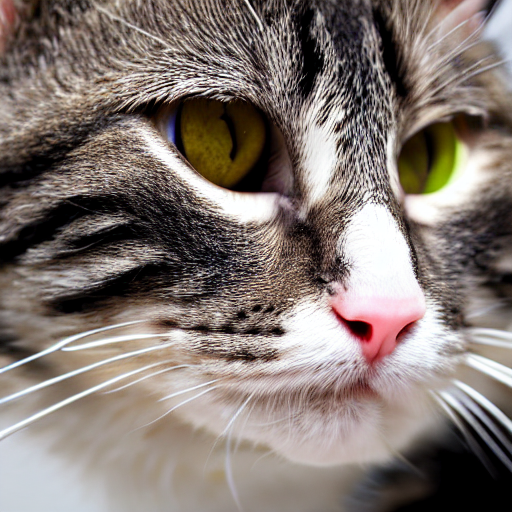

In [109]:
agent.run("Generate an image of a cat")

In [111]:
agent.run("Generate an image of a cat, caption it, and speak the caption and show the image")

==Explanation from the agent==
I will use the following  tools: `image_generator` to generate an image of a cat, `image_captioner` to caption the image, and `text_reader` to read the caption out loud.


==Code generated by the agent==
image = image_generator(prompt="a cat")
caption = image_captioner(image)
print(f"Caption: {caption}")
audio_caption = text_reader(caption)


==Result==


  0%|          | 0/25 [00:00<?, ?it/s]

Caption: a cat with green eyes


Found cached dataset cmu-arctic-xvectors (/home/susnato/.cache/huggingface/datasets/Matthijs___cmu-arctic-xvectors/default/0.0.1/a62fea1f9415e240301ea0042ffad2a3aadf4d1caa7f9a8d9512d631723e781f)


In [119]:
from pyannote.audio import Pipeline

diarization_pipeline = Pipeline.from_pretrained(
    "pyannote/speaker-diarization@2.1", # may need to use auth token in future
)

In [120]:
from datasets import load_dataset

concatenated_librispeech = load_dataset(
    "sanchit-gandhi/concatenated_librispeech", split="train", streaming=True
)
sample = next(iter(concatenated_librispeech))

In [121]:
from IPython.display import Audio

Audio(sample["audio"]["array"], rate=sample["audio"]["sampling_rate"])

In [122]:
import torch

input_tensor = torch.from_numpy(sample["audio"]["array"][None, :]).float()
outputs = diarization_pipeline(
    {"waveform": input_tensor, "sample_rate": sample["audio"]["sampling_rate"]}
)

outputs.for_json()["content"]

[{'segment': {'start': 0.4978125, 'end': 14.520937500000002},
  'track': 'B',
  'label': 'SPEAKER_01'},
 {'segment': {'start': 15.364687500000002, 'end': 21.3721875},
  'track': 'A',
  'label': 'SPEAKER_00'}]

In [123]:
from transformers import pipeline

asr_pipeline = pipeline(
    "automatic-speech-recognition",
    model="openai/whisper-base",
)

In [124]:
asr_pipeline(
    sample["audio"].copy(),
    generate_kwargs={"max_new_tokens": 256},
    return_timestamps=True,
)

{'text': " The second and importance is as follows. Sovereignty may be defined to be the right of making laws. In France, the king really exercises a portion of the sovereign power, since the laws have no weight. He was in a favored state of mind, owing to the blight his wife's action threatened to cast upon his entire future.",
 'chunks': [{'timestamp': (0.0, 3.56),
   'text': ' The second and importance is as follows.'},
  {'timestamp': (3.56, 7.84),
   'text': ' Sovereignty may be defined to be the right of making laws.'},
  {'timestamp': (7.84, 13.88),
   'text': ' In France, the king really exercises a portion of the sovereign power, since the laws have'},
  {'timestamp': (13.88, 15.48), 'text': ' no weight.'},
  {'timestamp': (15.48, 19.44),
   'text': " He was in a favored state of mind, owing to the blight his wife's action threatened to"},
  {'timestamp': (19.44, 21.28), 'text': ' cast upon his entire future.'}]}

In [126]:
from speechbox import ASRDiarizationPipeline

pipeline = ASRDiarizationPipeline(
    asr_pipeline=asr_pipeline, diarization_pipeline=diarization_pipeline
)

In [127]:
pipeline(sample["audio"].copy())

[{'speaker': 'SPEAKER_01',
  'text': ' The second and importance is as follows. Sovereignty may be defined to be the right of making laws. In France, the king really exercises a portion of the sovereign power, since the laws have no weight.',
  'timestamp': (0.0, 15.48)},
 {'speaker': 'SPEAKER_00',
  'text': " He was in a favored state of mind, owing to the blight his wife's action threatened to cast upon his entire future.",
  'timestamp': (15.48, 21.28)}]

In [131]:
def tuple_to_string(start_end_tuple, ndigits=1):
    return str((round(start_end_tuple[0], ndigits), round(start_end_tuple[1], ndigits)))


def format_as_transcription(raw_segments):
    return " \n\n ".join(
        [
            chunk["speaker"] + " " + tuple_to_string(chunk["timestamp"]) + chunk["text"]
            for chunk in raw_segments
        ]
    )

In [132]:
outputs = pipeline(sample["audio"].copy())

format_as_transcription(outputs)

"SPEAKER_01 (0.0, 15.5) The second and importance is as follows. Sovereignty may be defined to be the right of making laws. In France, the king really exercises a portion of the sovereign power, since the laws have no weight. \n\n SPEAKER_00 (15.5, 21.3) He was in a favored state of mind, owing to the blight his wife's action threatened to cast upon his entire future."

In [201]:
from transformers import AutoModel

model = AutoModel.from_pretrained("suno/bark-small").to(device)

In [150]:
from transformers import pipeline

asr_pipe = pipeline("automatic-speech-recognition", model="openai/whisper-base", device=device)

def translate(audio):
    outputs = asr_pipe(audio, max_new_tokens=256, generate_kwargs={"task": "translate"})
    return outputs["text"]

In [136]:
Audio(sample["audio"]["array"], rate=sample["audio"]["sampling_rate"])

In [161]:
tokenized_text = tokenizer.encode(translate(sample["audio"].copy()), return_tensors="pt")

In [164]:
opts = model.generate(tokenized_text)

In [179]:
print(opts.numpy())

[[61949  1997     9 11211    89   438     5    25  4435 23736 11409    18
   2114  1044    24  1430  2372   209   168     5  7750  1878   473  1776
     11  1096 29863    24    38  5734   572   161     5   248   113   173
    109  6195  2208   264     5    49   143  1135     6  8307  1892    33
  33780    91     6   417   143  1135     6   358  8864    18  1491    91
     15  8514   355     5    40     0]]


In [180]:
tokenizer.convert_ids_to_tokens(opts.numpy()[0])

['<pad>',
 '▁दूसरा',
 '▁और',
 '▁महत्व',
 '▁इस',
 '▁प्रकार',
 '▁है',
 '▁कि',
 '▁शासन',
 'पाल',
 'िका',
 '▁को',
 '▁विधि',
 '▁बनाने',
 '▁का',
 '▁अधिकार',
 '▁माना',
 '▁जा',
 '▁सकता',
 '▁है',
 '▁फ्रांस',
 '▁मे',
 '▁राजा',
 '▁वास्तव',
 '▁में',
 '▁प्रभु',
 'सत्ता',
 '▁का',
 '▁एक',
 '▁अंश',
 '▁प्रयोग',
 '▁करता',
 '▁है',
 '▁क्योंकि',
 '▁उसके',
 '▁पास',
 '▁कोई',
 '▁भार',
 '▁नही',
 '▁होता',
 '▁है',
 '▁वह',
 '▁अपनी',
 '▁पत्नी',
 '▁के',
 '▁समस्त',
 '▁भविष्य',
 '▁पर',
 '▁प्रहार',
 '▁करने',
 '▁के',
 '▁कारण',
 '▁अपनी',
 '▁पत्नी',
 '▁के',
 '▁कार्य',
 'काल',
 '▁को',
 '▁समाप्त',
 '▁करने',
 '▁की',
 '▁धमकी',
 '▁देता',
 '▁है',
 '।',
 '</s>']

In [200]:
from transformers import MarianTokenizer

In [185]:
martian_mt_model = MarianMTModel.from_pretrained("AbhirupGhosh/opus-mt-finetuned-en-hi")
martian_mt_tokenizer = MarianTokenizer.from_pretrained("AbhirupGhosh/opus-mt-finetuned-en-hi")

def translate_english_to_hindi(english_text):
    tokenized_text = martian_mt_tokenizer.encode(english_text, return_tensors="pt")
    generated_token_ids = martian_mt_model.generate(tokenized_text)
    hindi_text = martian_mt_tokenizer.decode(generated_token_ids.numpy()[0])
    hindi_text = hindi_text.replace("</s>", "")
    hindi_text = hindi_text.replace("<pad>", "")

    return hindi_text

In [187]:
hindi_text = translate_english_to_hindi(translate(sample["audio"].copy()))

In [196]:
from transformers import AutoProcessor, AutoModel

processor = AutoProcessor.from_pretrained("suno/bark-small")
model = AutoModel.from_pretrained("suno/bark-small")


def synthesise(text):
    inputs = processor(text=text, return_tensors="pt")
    speech_values = model.generate(**inputs)

    return speech_values.cpu()

In [197]:
audio_data = synthesise(hindi_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:10000 for open-end generation.


In [208]:
audio_data.cpu()

tensor([[ 8.0360e-02,  8.4459e-02,  8.7803e-02,  ..., -9.7411e-05,
         -9.9977e-05, -6.9143e-05]])

In [203]:
audio_data.max(), audio_data.min()

(tensor(0.7637), tensor(-0.7891))

In [199]:
Audio(audio_data, rate=22050)

In [209]:
np.iinfo(np.int16).max, np.iinfo(np.int16).min

(32767, -32768)